In [2]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the "../input/" directory.
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # Any results you write to the current directory are saved as output.

In [3]:
import gc
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from keras import backend as K
warnings.filterwarnings(action='ignore')

K.image_data_format()

'channels_last'

In [7]:
DATA_PATH = '/Users/asmaaaly/Minerva_Shit/Capstone/Minerva_Capstone/dogs-vs-cats-redux-kernels-edition/'

import re
list_for_df = []
for traindata in os.listdir(os.path.join(DATA_PATH, 'train/')):
#   print(traindata)
  tmplist = []
  if traindata[0] == 'c':
    tmplist.append(0)
  else:
    tmplist.append(1)
  tmplist.append(traindata)
  list_for_df.append(tmplist)

train_df = pd.DataFrame(data=list_for_df, columns=['class','fname'])
train_df['class'] = train_df['class'].astype('str')
train_df.head()
train_df.shape

(25000, 2)

In [8]:
train_df.head()

,class,fname
0,1,dog.8011.jpg
1,0,cat.5077.jpg
2,1,dog.7322.jpg
3,0,cat.2718.jpg
4,0,cat.10151.jpg


In [9]:
list_for_df = []
for testdata in os.listdir(os.path.join(DATA_PATH, 'test/')):
#   print(traindata)
  tmplist = []
  tmplist.append(testdata)
  list_for_df.append(tmplist)

df_test = pd.DataFrame(data=list_for_df, columns=['fname'])

In [10]:
df_test.head()

,fname
0,9733.jpg
1,63.jpg
2,6400.jpg
3,823.jpg
4,4217.jpg


In [11]:
df_test.shape

(12500, 1)

# Load Data

In [12]:
from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(train_df)

In [13]:
df_train.head()

,class,fname
17997,0,cat.62.jpg
5357,0,cat.7705.jpg
6212,0,cat.3358.jpg
4509,0,cat.6586.jpg
1801,0,cat.2519.jpg


In [14]:
df_val.head()

,class,fname
14090,1,dog.7411.jpg
5386,1,dog.176.jpg
2599,0,cat.1159.jpg
11037,1,dog.5235.jpg
10382,1,dog.5182.jpg


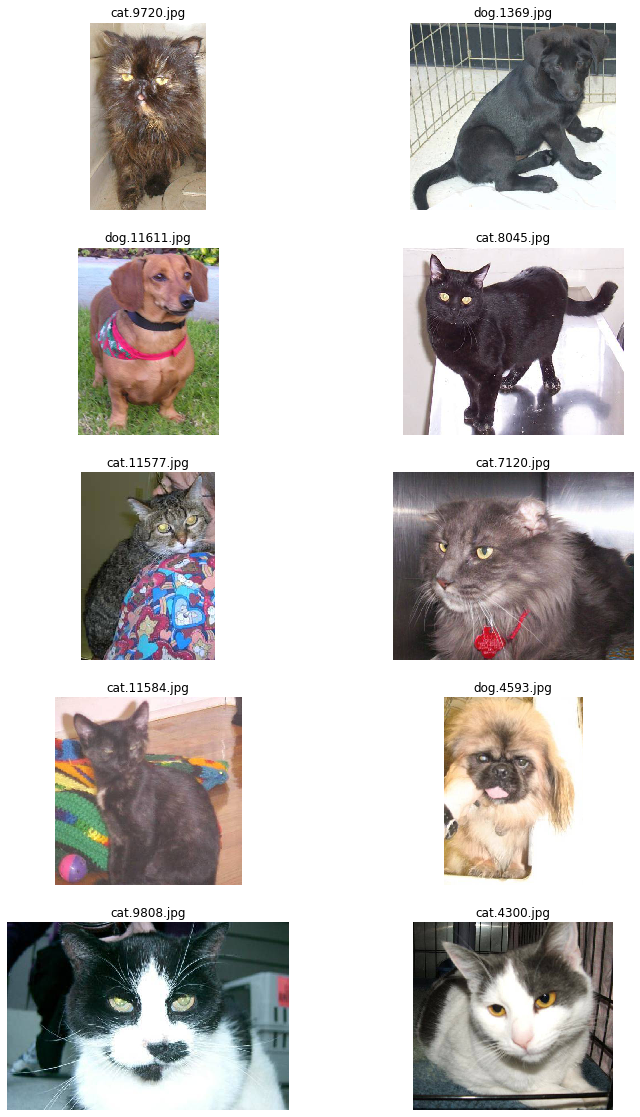

In [15]:
original_dataset_dir = os.path.join(DATA_PATH, 'train/')

import PIL
from PIL import ImageDraw

tmp_imgs = df_train['fname'][100:110]
plt.figure(figsize=(12,20))

for num, f_name in enumerate(tmp_imgs):
  img = PIL.Image.open(os.path.join(original_dataset_dir, f_name))
  plt.subplot(5,2,num+1)
  plt.title(f_name)
  plt.imshow(img)
  plt.axis('off')

# Xception with fine tuning + data_gen

In [5]:
import plaidml.keras
plaidml.keras.install_backend()
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import keras
import keras.applications as kapp
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

conv_base = kapp.Xception(weights='imagenet',
                  include_top=False,
                  input_shape=(224,224,3))

conv_base.summary()

                 
__________________________________________________________________________________________________
block5_sepconv1 (SeparableConv2 (None, 14, 14, 728)  536536      block5_sepconv1_act[0][0]        
__________________________________________________________________________________________________
block5_sepconv1_bn (BatchNormal (None, 14, 14, 728)  2912        block5_sepconv1[0][0]            
__________________________________________________________________________________________________
block5_sepconv2_act (Activation (None, 14, 14, 728)  0           block5_sepconv1_bn[0][0]         
__________________________________________________________________________________________________
block5_sepconv2 (SeparableConv2 (None, 14, 14, 728)  536536      block5_sepconv2_act[0][0]        
__________________________________________________________________________________________________
block5_sepconv2_bn (BatchNormal (None, 14, 14, 728)  2912        block5_sepconv2[0][0]     

In [19]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name.split('_')[0] == 'block1':
    set_trainable = True
  if layer.name.split('_')[0] == 'block2':
    set_trainable = True
  if layer.name.split('_')[0] == 'block13':
    set_trainable = True
  if layer.name.split('_')[0] == 'block14':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [27]:
from keras.preprocessing.image import ImageDataGenerator

img_size = (224,224)
nb_train_samples = len(df_train)
nb_validation_samples = len(df_val)
nb_test_samples = len(df_test)
epochs = 12
batch_size = 32

# Define Generator config
train_datagen = ImageDataGenerator(
  horizontal_flip = True,
  vertical_flip = False,
  zoom_range = 0.10,
  rescale=1./255
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

original_dataset_dir = os.path.join(DATA_PATH, 'train/')

train_generator = train_datagen.flow_from_dataframe(
    dataframe = df_train,
    directory = original_dataset_dir,
    x_col = 'fname',
    y_col = 'class',
    target_size = img_size,
    color_mode = 'rgb',
    class_mode = 'binary',
    batch_size = batch_size,
    seed = 42
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe = df_val,
    directory = original_dataset_dir,
    x_col = 'fname',
    y_col = 'class',
    target_size = img_size,
    color_mode = 'rgb',
    class_mode = 'binary',
    batch_size = batch_size,
    shuffle = False
)

test_data_path = os.path.join(DATA_PATH, 'test/')

test_generator = test_datagen.flow_from_dataframe(
    dataframe = df_test,
    directory = test_data_path,
    x_col = 'fname',
    y_col = None,
    target_size = img_size,
    color_mode = 'rgb',
    class_mode = None,
    batch_size = batch_size,
    shuffle = False
)

Found 18750 validated image filenames belonging to 2 classes.
Found 6250 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames.


In [28]:
from sklearn.metrics import f1_score

def micro_f1(y_true, y_pred):
  return f1_score(y_true, y_pred, average='micro')

def get_step(num_samples, batch_size):
  if (num_samples % batch_size) > 0:
    return (num_samples // batch_size) + 1
  else:
    return num_samples // batch_size

import keras

class LossHistory(keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.losses = []
    self.val_losses = []
    self.acces = []
    self.val_acces = []


  def on_batch_end(self, batch, logs={}):
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))
    self.acces.append(logs.get('acc'))
    self.val_acces.append(logs.get('val_acc'))

loss_history = LossHistory()

In [24]:
def freeze(model):
    """Freeze model weights in every layer."""
    for layer in model.layers:
        layer.trainable = False

        if isinstance(layer, models.Model):
            freeze(layer)

In [31]:
from keras import models
from keras import layers
from keras import optimizers

from keras.callbacks import ModelCheckpoint, EarlyStopping

filepath = "Xception_bin.h5"

es = EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=1, mode='auto')
callbackList = [es, loss_history]


model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
# model.add(layers.Flatten())
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])

history = model.fit_generator(train_generator,
                   steps_per_epoch=100,
                   epochs =10,
                   validation_data=validation_generator,
                   validation_steps=100,
                   callbacks=callbackList)

# freeze 해줘야함
from keras import models

def freeze(model):
    """Freeze model weights in every layer."""
    for layer in model.layers:
        layer.trainable = False

        if isinstance(layer, models.Model):
            freeze(layer)

freeze(model)
model.save(filepath)

Epoch 1/10
100/100 [==============================] - 3055s 31s/step - loss: 7.8777 - acc: 0.0000e+00 - val_loss: 8.0540 - val_acc: 0.0000e+00
Epoch 2/10
 16/100 [===>..........................] - ETA: 37:36 - loss: 8.1220 - acc: 0.0000e+00

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

history = model.history

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(loss_history.acces)
plt.plot(loss_history.val_acces)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(loss_history.losses)
plt.plot(loss_history.val_losses)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# get answer

In [ ]:
steps = len(df_test) // batch_size + 1

In [ ]:
mypred = model.predict_generator(
    test_generator,
    steps=steps
)

In [ ]:
mypred_val = mypred
mypred_val.shape

# check_by_eye

In [ ]:
df_test.head()

In [ ]:
id_val = df_test['fname'].str.split(".").str[0].values
id_val

In [ ]:
np.shape(id_val)

In [ ]:
sptl = df_test['fname'][:30].values

In [ ]:
sptl

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,40))

testdir = os.path.join(DATA_PATH, 'test/test')

import PIL

num = 0

for fname in sptl:
  img = PIL.Image.open(os.path.join(testdir, fname))
  plt.subplot(8,4,num+1)
  if mypred_val[num]<0.5:
    plt.title('cat')
  else:
    plt.title('dog')
  plt.axis('off')
  plt.imshow(img)
  num += 1

# submit!

In [ ]:
submission = pd.read_csv(os.path.join(DATA_PATH, "sample_submission.csv"))

In [ ]:
submission['id'] = id_val
submission['label'] = mypred_val

In [ ]:
submission.head()

In [ ]:
my_submission = submission.set_index('id')

In [ ]:
my_submission.head()

In [ ]:
my_submission.to_csv("Xception_submit.csv")